In [ ]:
!PYTHONHASHSEED=0

In [ ]:
# Import Tensorflow/Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [ ]:
import os
import pathlib
import random
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

from keras.utils import image_dataset_from_directory
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [ ]:
# Import other modules
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import seaborn as sns


In [ ]:
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Downloading the Dataset

In [ ]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
copyfile('gdrive/My Drive/DL_project/flower_photos.zip', 'flower_photos.zip')
zip = zipfile.ZipFile('flower_photos.zip')
zip.extractall()
zip.close()

In [ ]:
base_path = '/content/flower_photos 2'

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.3

Training set

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(img_height,img_width),
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            validation_split = validation_split,
                                                            shuffle=True,
                                                            seed=123)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.


Validation set

In [ ]:
val_dataset = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(img_height,img_width),
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            subset='validation',
                                                            validation_split = validation_split,
                                                            shuffle=True,
                                                            seed=123)

Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_ds = val_dataset.take((val_batches) // 3)
val_ds = val_dataset.skip((val_batches) // 3)

In [ ]:
print("Number of batches in train dataset:", len(train_ds))
print("Number of batches in validation dataset:", len(val_ds))
print("Number of batches in test dataset:", len(test_ds))

Number of batches in train dataset: 81
Number of batches in validation dataset: 24
Number of batches in test dataset: 11


Visualization of the train set

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


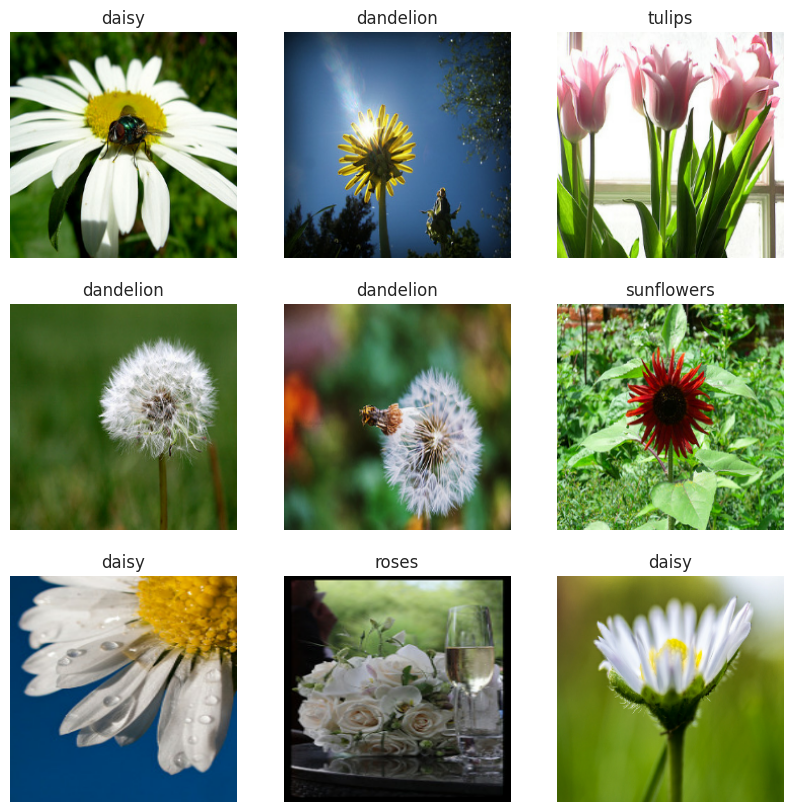

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_index = np.argmax(labels[i])  # convert one-hot label to class index
    plt.title(class_names[class_index])
    plt.axis("off")

## Data augmentation

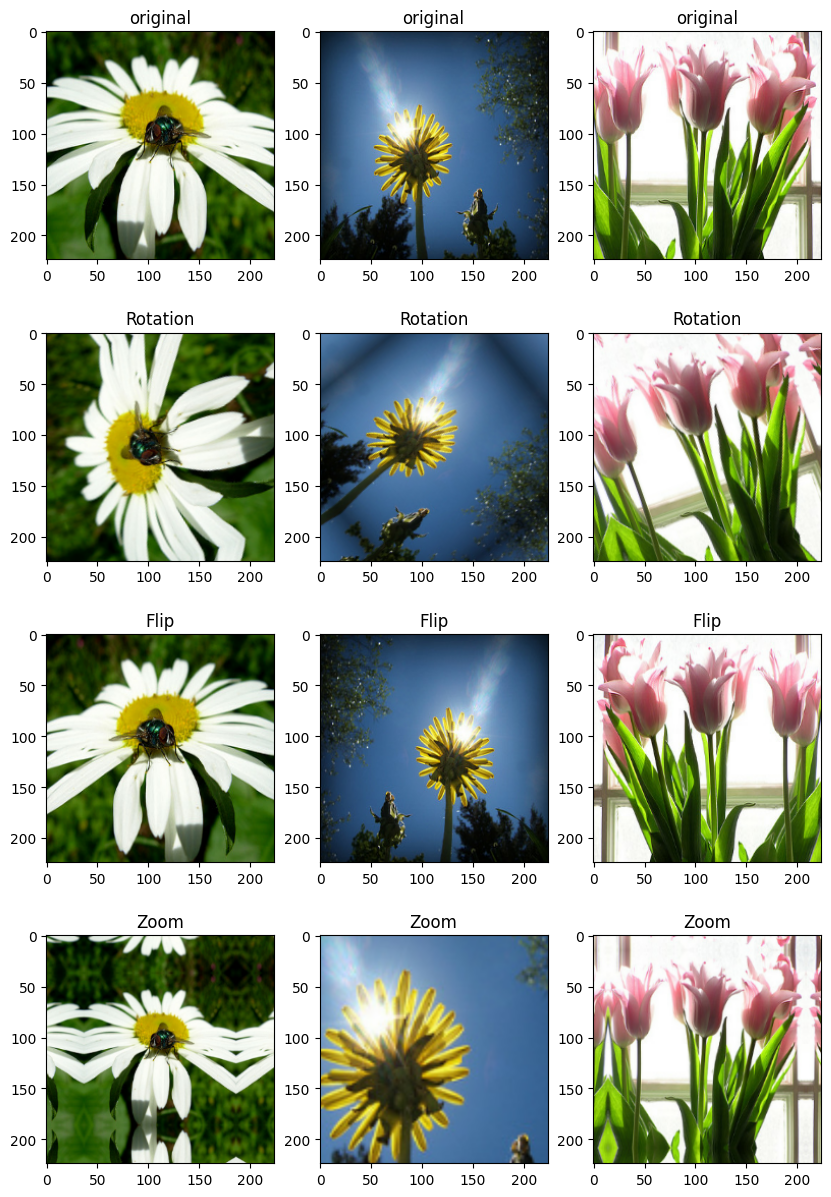

In [ ]:
zoom = tf.keras.layers.RandomZoom(0.5)
rotation = tf.keras.layers.RandomRotation(0.4)
flip = tf.keras.layers.RandomFlip('horizontal')

fig, ax = plt.subplots(4, 3, figsize=(10,15))

for images, labels in train_ds.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")

        ax[1][i].imshow(rotation(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("Rotation")

        ax[2][i].imshow(flip(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("Flip")

        ax[3][i].imshow(zoom(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("Zoom")
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomZoom(0.5),
        keras.layers.RandomRotation(0.4),
        keras.layers.RandomFlip('horizontal'),
    ]
)

In [ ]:
def plot_history(history):

    sns.set_style('darkgrid')
    sns.set(rc={'figure.figsize': (10, 6)})

    plt.subplot(1, 2, 1)
    loss_plot = sns.lineplot(data=history['loss'], color = 'blue', label= 'Train Loss', lw=1)
    val_loss_plot = sns.lineplot(data=history['val_loss'], color = 'red', label= 'Valid Loss', lw=1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    acc_plot = sns.lineplot(data=history['accuracy'], color = 'blue', label= 'Train Accuracy', lw=1)
    val_acc_plot = sns.lineplot(data=history['val_accuracy'],  color = 'red', label= 'Valid Accuracy', lw=1)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.suptitle('Model Performance', fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
tf.keras.applications.vgg16.VGG16(include_top=True,
                                  weights='imagenet',
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )

553467096/553467096 [==============================] - 17s 0us/step


# VGG-16 and Fine-Tuning

In [ ]:
# Specify the model input shape.
input_shape = (224, 224, 3)

NUM_CLASSES=5

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
print(vgg16_conv_base.summary())

Loading model with ImageNet weights...
58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                       

In [ ]:
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
vgg16_conv_base.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = 4
num_layers = len(vgg16_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")

print(vgg16_conv_base.summary())

FREEZING LAYER: <keras.engine.input_layer.InputLayer object at 0x7f2b8afe7fa0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f2b8afe6470>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f2b8afe7550>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f2b8afe7cd0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f2b8afe76d0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f2b8afe6350>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f2b8d48c520>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f2b8b729de0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f2b8b0185b0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f2b8b01a6b0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f2b8b01b8b0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D ob

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = data_augmentation(x)

x = vgg16_conv_base(x)

x = Flatten(name="flatten")(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)

x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)

# The final `Dense` layer with the number of classes.
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)

print(model_vgg16_finetune.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# Train the Model.
training_results = model_vgg16_finetune.fit(train_ds,
                                            epochs=30,
                                            validation_data=val_dataset,
                                            callbacks=[tl_checkpoint_1, early_stop, plot_loss],
                                            verbose=1)


Epoch 1/30
36/81 [============>.................] - ETA: 19:38 - loss: 1.2472 - accuracy: 0.5330

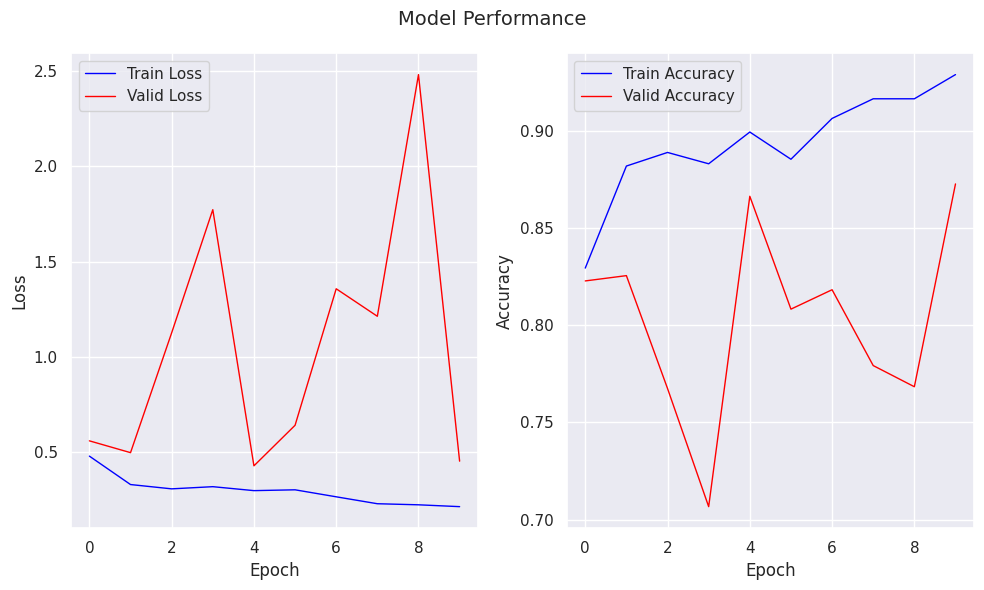

In [ ]:
plot_history(training_results.history)

In [ ]:
# save model and history
model_vgg16_finetune.save('/content/gdrive/MyDrive/Models_DL_project/VGG16Finetune')
np.save('/content/gdrive/MyDrive/Models_DL_project/VGG16Finetune_history.npy', training_results.history)

In [ ]:
# upload history
path_history = '/content/gdrive/MyDrive/Models_DL_project/VGG16Finetune_history.npy'
VGG16Finetune_history = np.load(path_history, allow_pickle=True).item()

# upload model
VGG16Finetune = keras.models.load_model("/content/gdrive/MyDrive/Models_DL_project/VGG16Finetune")


In [ ]:
# test accuracy
loss, acc = VGG16Finetune.evaluate(test_ds)
print('Test loss:', loss)
print("Test Accuracy", acc)

11/11 [==============================] - 3s 124ms/step - loss: 0.5554 - accuracy: 0.8153
Test loss: 0.5553891062736511
Test Accuracy 0.8153409361839294
